In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns #for plotting
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import average_precision_score,f1_score,precision_score,recall_score,auc,log_loss,confusion_matrix


In [3]:
data = pd.read_csv("/home/shri/Documents/file1.csv")
data = data[["Score","text"]]
clean_data = data['text'].tolist()

In [4]:
data.head(2)

,Score,text
0,1,received shipment could hardly wait try produc...
1,0,really good idea final product outstanding use...


## BOW Without optimal alpha

In [5]:
counting_var = CountVectorizer(ngram_range = (1,2), min_df=10, max_features=4000)
bi_gram = counting_var.fit_transform(np.array(clean_data))
print("Shape of BOW : {}".format(bi_gram.get_shape()))
print("Unique words : {}".format(bi_gram.get_shape()[1]))

Shape of BOW : (1500, 1032)
Unique words : 1032


In [6]:
scores = data['Score'].get_values()
len(scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """Entry point for launching an IPython kernel.


1500

In [7]:
# Total data frame
x = bi_gram[0:10000]
# this is only Score/rating  of data
y = scores

In [8]:
x.shape

(1500, 1032)

In [9]:
#splitting the train and test data

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3, random_state=0)


In [10]:
#x_1 = np.array(x_1)

Y_train = np.array(Y_train)

#x_test = np.array(x_test)

y_test = np.array(Y_test)



In [11]:
clf = BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
clf.fit(X_train,Y_train)            
pred = clf.predict(X_test)

In [12]:
print("Accuracy Of NB Classifier using Accuracy Score: ",accuracy_score(Y_test,pred) * 100)
print("Accuracy Of NB Classifier using F1 Score: ",f1_score(Y_test,pred) * 100)
print("Accuracy Of NB Classifier Precision Score: ",precision_score(Y_test,pred) * 100)
print("Accuracy Of NB Classifier using Recall Sscore: ",recall_score(Y_test,pred) * 100)

Accuracy Of NB Classifier using Accuracy Score:  75.55555555555556
Accuracy Of NB Classifier using F1 Score:  85.82474226804123
Accuracy Of NB Classifier Precision Score:  84.7328244274809
Accuracy Of NB Classifier using Recall Sscore:  86.94516971279373


In [13]:
fpr, tpr, thresholds = roc_curve(Y_test,pred)
acc = auc(fpr, tpr)
print("Area Under The Curve is : ",acc)
print("Log Loss val can be 0 to infinity, 0 is best Our LogLoss is:",log_loss(Y_test, pred,normalize=True) )

Area Under The Curve is :  0.4869646545341179
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 8.442918620635526


In [14]:
print("Confusion Matrix")
tn, fp, fn, tp = confusion_matrix(Y_test, pred).ravel()
tpr = tp/(fn+tp)
tnr = tn/(tn+fp)
fnr = fn/(fn+tp)
fpr = fp/(tn+fp)

print("TPR :%f,TNR : %f,FNR : %f,FPR: %f"%(tpr,tnr,fnr,fpr))

Confusion Matrix
TPR :0.869452,TNR : 0.104478,FNR : 0.130548,FPR: 0.895522


# Using Optimal Alpha :

## * BOW

In [15]:
def convToNpArray(arr):
    if(type(arr) == list):
        print("mp")
        arr = np.array(arr)
        return arr
    else:
        return arr;

In [16]:
def alpha_cross_validation(x,y,alphas):
    #list of alpha values
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)
    
    x_train = convToNpArray(x_train)
    x_test = convToNpArray(x_test)
    y_train = convToNpArray(y_train)
    y_test = convToNpArray(y_test)

    Alphas = list(range(1,alphas));
    
    tscv_scores = []
    
    for alph in Alphas:
        
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(x_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]
            
            #alpha is used to avoide Errors, its ntg but Laplace Smoothing
            # Binarize=0 or any num indicates it converts every feature into bin value as it supports only bin values
            clf = BernoulliNB(alpha=alph, binarize=0.0, class_prior=None, fit_prior=True)
            clf.fit(X_train,Y_train)
            
            pred = clf.predict(X_test)
            acc = accuracy_score(Y_test, pred, normalize=True )*float(100)
        tscv_scores.append(acc)

    # determining best Alpha
    optimal_alpha = Alphas[tscv_scores.index(max(tscv_scores))]
    print("optimal Alpha based on Accuracy Percentage: ",optimal_alpha)
    plt.rcParams['figure.figsize'] = [20,10]
    plt.plot(Alphas, tscv_scores)
    
    for xy in zip(Alphas, np.round(tscv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Alpha')
    plt.ylabel('Accuracy Percentage')
    plt.show()
    

optimal Alpha based on Accuracy Percentage:  24


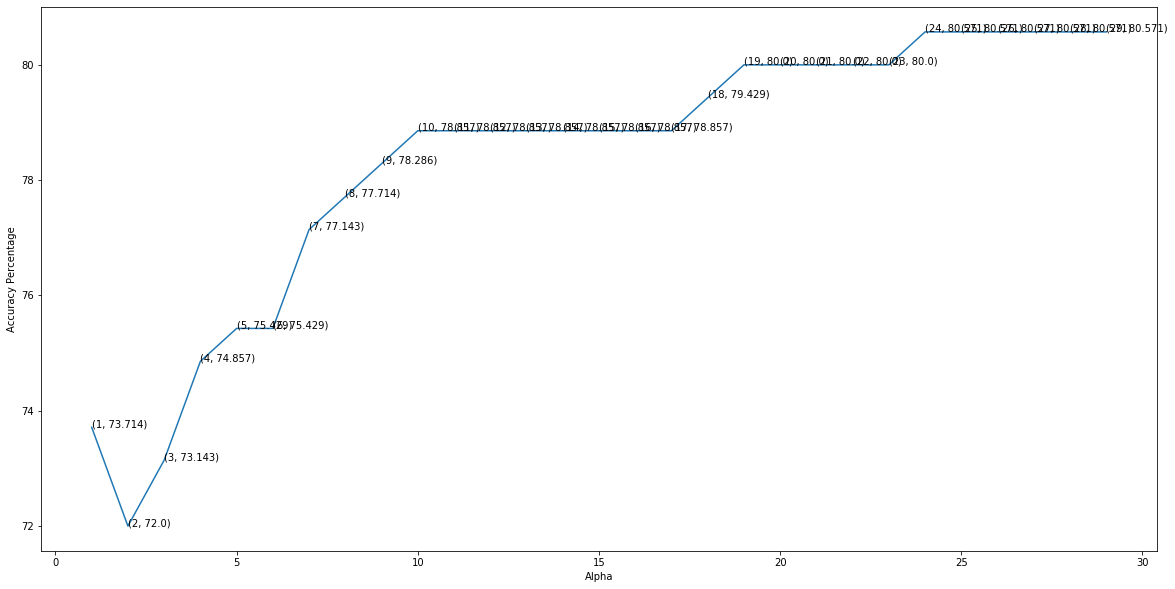

In [17]:
alpha_cross_validation(x,y,30)

In [18]:
def alpha_cv_matrix(x,y,alpha):
    #list of alpha values
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)
    
    x_train = convToNpArray(x_train)
    x_test = convToNpArray(x_test)
    y_train = convToNpArray(y_train)
    y_test = convToNpArray(y_test)

    
    NB_Optimal = BernoulliNB(alpha=alpha, binarize=0.0, class_prior=None, fit_prior=True)

    NB_Optimal.fit(x_train,y_train)

    pred = NB_Optimal.predict(x_test)

    print("#"*75)

    print("Accuracy Of NB Classifier using Accuracy Score: ",accuracy_score(y_test,pred) * 100)

    print("Accuracy Of NB Classifier using F1 Score: ",f1_score(y_test,pred) * 100)

    print("Accuracy Of NB Classifier Precision Score: ",precision_score(y_test,pred) * 100)

    print("Accuracy Of NB Classifier using Recall Sscore: ",recall_score(y_test,pred) * 100)


    fpr, tpr, thresholds = roc_curve(y_test,pred)
    acc = auc(fpr, tpr)
    print("Area Under The Curve is : ",acc)

    print("Log Loss val can be 0 to infinity, 0 is best Our LogLoss is:",log_loss(y_test, pred,normalize=True) )

    print("#"*75)
    print("Confusion Matrix")
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    tpr = tp/(fn+tp)
    tnr = tn/(tn+fp)
    fnr = fn/(fn+tp)
    fpr = fp/(tn+fp)

    print("TPR :%f,TNR : %f,FNR : %f,FPR: %f"%(tpr,tnr,fnr,fpr))

In [19]:
alpha_cv_matrix(x,y,24)

###########################################################################
Accuracy Of NB Classifier using Accuracy Score:  84.44444444444444
Accuracy Of NB Classifier using F1 Score:  91.56626506024095
Accuracy Of NB Classifier Precision Score:  85.01118568232661
Accuracy Of NB Classifier using Recall Sscore:  99.21671018276761
Area Under The Curve is :  0.4960835509138381
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 5.37281760149238
###########################################################################
Confusion Matrix
TPR :0.992167,TNR : 0.000000,FNR : 0.007833,FPR: 1.000000


##  * Tf_idf

In [20]:
tf_idf = TfidfVectorizer()
tf_idf.fit(np.array(clean_data))
tf_idf = tf_idf.transform(np.array(clean_data))

In [21]:

# Total data frame

x = tf_idf[0:1500]

# this is only Score/rating  of data

y = scores

optimal Alpha based on Accuracy Percentage:  5


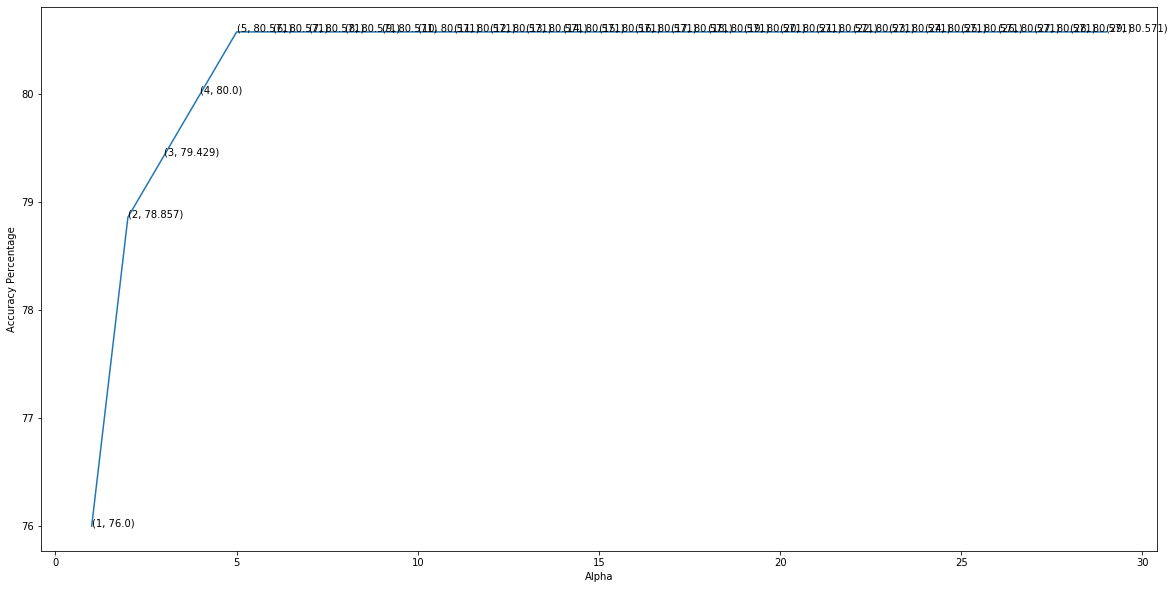

In [22]:
alpha_cross_validation(x,y,30)

In [23]:
alpha_cv_matrix(x,y,5)

###########################################################################
Accuracy Of NB Classifier using Accuracy Score:  84.88888888888889
Accuracy Of NB Classifier using F1 Score:  91.82692307692308
Accuracy Of NB Classifier Precision Score:  85.07795100222717
Accuracy Of NB Classifier using Recall Sscore:  99.73890339425587
Area Under The Curve is :  0.49869451697127937
Log Loss val can be 0 to infinity, 0 is best Our LogLoss is: 5.2193119286261105
###########################################################################
Confusion Matrix
TPR :0.997389,TNR : 0.000000,FNR : 0.002611,FPR: 1.000000
